# Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import sklearn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import nltk
from nltk.tokenize import word_tokenize
import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import pickle

# Load Data Train and Data Test

In [2]:
train = pd.read_csv('./data_worthcheck/train.csv', index_col=0)
test = pd.read_csv('./data_worthcheck/test.csv')

In [3]:
train.head()

,text_a,label
0,betewe buka twitter cuman ngetweet liat home b...,no
1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,no
2,e100ss gini buka informasi sejelas nya identit...,yes
3,neng solo wes ono terduga corona cobo neng ati...,no
4,midiahn nii akun gak takut takut nya isu coron...,no


In [4]:
test.head()

,text_a,label
0,jek dajal ga depok bang,no
1,detikcom untung depok masuk wilayah nya ridwan...,no
2,df dom jakarta depok yg gunain vc cabang nya c...,no
3,your2rl depok jkt,no
4,doakan indonesia selamat virus corona pkb depo...,yes


# Data Understanding

## Data Description

In [5]:
train.shape

(21601, 2)

In [6]:
test.shape

(2800, 2)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21601 entries, 0 to 21600
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text_a  21601 non-null  object
 1   label   21601 non-null  object
dtypes: object(2)
memory usage: 506.3+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text_a  2800 non-null   object
 1   label   2800 non-null   object
dtypes: object(2)
memory usage: 43.9+ KB


Dataset terbagi menjadi data train dan data test. Dataset terdiri dari 2 fitur yaitu text_a dan label. Data train terdiri dari 21601 row sedangkan data test terdiri dari 2800 row.

## Identifikasi Missing Value

In [9]:
train.isna().sum()

text_a    0
label     0
dtype: int64

In [10]:
test.isna().sum()

text_a    0
label     0
dtype: int64

Tidak ada missing value

## Identifikasi Duplicate Value

In [11]:
train.duplicated().sum()

5252

In [12]:
test.duplicated().sum()

3

Terdapat nilai duplikat pada data. Untuk data train terdapat 5252 data duplicate dan untuk data test terdapat 3 data duplicate.

## Visualisasikan Data

Text(0.5, 0.98, 'Banyaknya Label untuk Data Training dan Data Test')

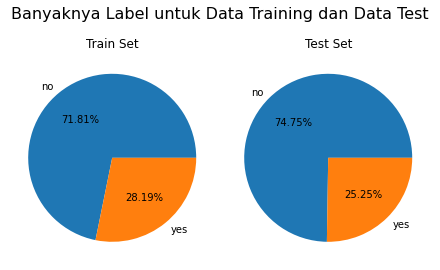

In [13]:
fig, ax = plt.subplots(1, 2, constrained_layout=True)
ax[0].pie(train["label"].value_counts(), labels=train["label"].value_counts().index.values, autopct='%1.2f%%')
ax[0].title.set_text("Train Set")
ax[1].pie(test["label"].value_counts(), labels=test["label"].value_counts().index.values, autopct='%1.2f%%')
ax[1].title.set_text("Test Set")
fig.suptitle("Banyaknya Label untuk Data Training dan Data Test", fontsize=16)

## Hilangkan Data Duplicate

In [14]:
train = train.drop_duplicates()
test = test.drop_duplicates()
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (16349, 2)
Test shape: (2797, 2)


Text(0.5, 0.98, 'Banyaknya Label untuk Data Training dan Data Test')

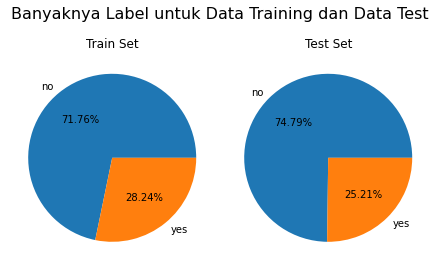

In [15]:
fig, ax = plt.subplots(1, 2, constrained_layout=True)
ax[0].pie(train["label"].value_counts(), labels=train["label"].value_counts().index.values, autopct='%1.2f%%')
ax[0].title.set_text("Train Set")
ax[1].pie(test["label"].value_counts(), labels=test["label"].value_counts().index.values, autopct='%1.2f%%')
ax[1].title.set_text("Test Set")
fig.suptitle("Banyaknya Label untuk Data Training dan Data Test", fontsize=16)

# Data Cleansing

## Case Folding: Lower Case

In [16]:
def lowercase(sentence):
    sentence = sentence.lower()
    return sentence

In [17]:
train["text_a"] = train["text_a"].apply(lowercase)
test["text_a"] = test["text_a"].apply(lowercase)

## Entity Masking

In [18]:
def entity_masking(sentence):
    email_1 = re.compile('\w+@\w+\.[a-z]{3}')
    email_2 = re.compile('\w+ (gmail|yahoo) (com| co id)')
    url_1 = re.compile('(https?:\/\/)(\s)?(www\.)?(\s?)(\w+\.)*([\w\-\s]+\/)*([\w-]+)\/?\?\w+=\w+')
    url_2 = re.compile('(https? )(\s)?(www )?(\s?)(\w+\ )+(com|go id|cf|co id)')
    url_3 = re.compile('https t co \w+')
    
    patterns = [(email_1, "_email_"), (email_2, "_email_"), (url_1, "_url_"), (url_2, "_url_"), (url_3, "_url_")]
    
    for pattern in patterns:
        sentence = pattern[0].sub(pattern[1], sentence)
    
    return sentence

In [19]:
train["text_a"] = train["text_a"].apply(entity_masking)
test["text_a"] = test["text_a"].apply(entity_masking)

## Case Folding: Removing Number

In [20]:
def removing_number(sentence):
    sentence = re.sub(r"\d+", "", sentence)
    return sentence

In [21]:
train["text_a"] = train["text_a"].apply(removing_number)
test["text_a"] = test["text_a"].apply(removing_number)

## Stopwords Elimination

In [22]:
def sw_elimination(sentence):
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    sentence = stopword.remove(sentence)
    return sentence

In [23]:
train["text_a"] = train["text_a"].apply(sw_elimination)
test["text_a"] = test["text_a"].apply(sw_elimination)

## Stemming

In [24]:
def stem(sentence):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    sentence = stemmer.stem(sentence)
    return sentence

In [25]:
train["text_a"] = train["text_a"].apply(sw_elimination)
test["text_a"] = test["text_a"].apply(sw_elimination)

# Data Preparation

In [26]:
X_train = train["text_a"].values
y_train = train["label"].values
X_test = test["text_a"].values
y_test = test["label"].values

In [27]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'no': 0, 'yes': 1}


# Features Extraction
Kami melakukan features extraction menggunakan TFIDF Vectorizer

In [28]:
tfidfvectorizer = TfidfVectorizer()
tfidfvectorizer.fit(X_train)

TfidfVectorizer()

In [29]:
X_train = tfidfvectorizer.transform(X_train).toarray()
X_test = tfidfvectorizer.transform(X_test).toarray()

In [30]:
X_train.shape

(16349, 40511)

In [31]:
X_test.shape

(2797, 40511)

Terdapat 40511 fitur. Untuk menyederhanakan fitur maka akan dilakukan dimentioal reduction menggunakan LSI (Latent Semantic Indexing)

# Dimentional Reduction: LSI

## 2 Component

In [32]:
# Define the number of topics or components
num_components_2 = 2

# Create SVD object
lsa_2 = TruncatedSVD(n_components=num_components_2, n_iter=100, random_state=42)

# Fit SVD model on data
lsa_2.fit(X_train)

TruncatedSVD(n_iter=100, random_state=42)

In [33]:
X_train_2 = lsa_2.transform(X_train)
X_test_2 = lsa_2.transform(X_test)

<AxesSubplot:xlabel='X1', ylabel='X2'>

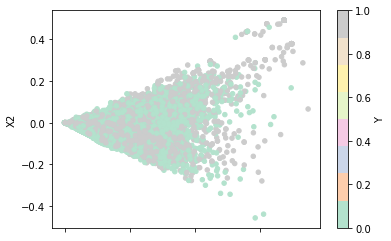

In [39]:
df2 = pd.DataFrame(X_train_2, columns=['X1', 'X2'])
df2['Y'] = y_train
df2.plot(kind='scatter', x='X1', y='X2', c='Y', cmap='Pastel2')

<AxesSubplot:xlabel='X1', ylabel='X2'>

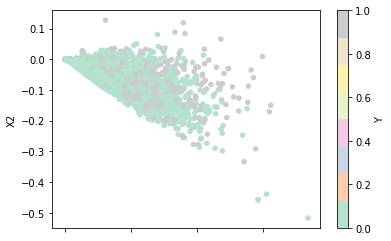

In [37]:
df2 = pd.DataFrame(X_test_2, columns=['X1', 'X2'])
df2['Y'] = y_test
df2.plot(kind='scatter', x='X1', y='X2', c='Y', cmap='Pastel2')

In [41]:
sc_2 = StandardScaler()
sc_2.fit(X_train_2)
X_train_2 = sc_2.transform(X_train_2)
X_test_2 = sc_2.transform(X_test_2)

## 10 Component

In [57]:
# Define the number of topics or components
num_components_10 = 10

# Create SVD object
lsa_10 = TruncatedSVD(n_components=num_components_10, n_iter=100, random_state=42)

# Fit SVD model on data
lsa_10.fit(X_train)

TruncatedSVD(n_components=10, n_iter=100, random_state=42)

In [58]:
X_train_10 = lsa_10.transform(X_train)
X_test_10 = lsa_10.transform(X_test)

In [59]:
sc_10 = StandardScaler()
sc_10.fit(X_train_10)
X_train_10 = sc_10.transform(X_train_10)
X_test_10 = sc_10.transform(X_test_10)

## 100 Component

In [65]:
# Define the number of topics or components
num_components_100 = 100

# Create SVD object
lsa_100 = TruncatedSVD(n_components=num_components_100, n_iter=100, random_state=42)

# Fit SVD model on data
lsa_100.fit(X_train)

TruncatedSVD(n_components=100, n_iter=100, random_state=42)

In [66]:
X_train_100 = lsa_100.transform(X_train)
X_test_100 = lsa_100.transform(X_test)

In [67]:
sc_100 = StandardScaler()
sc_100.fit(X_train_100)
X_train_100 = sc_100.transform(X_train_100)
X_test_100 = sc_100.transform(X_test_100)

# Modeling

In [43]:
def getPerformance(y_pred, y_test):
    ac = accuracy_score(y_pred, y_test)
    p = precision_score(y_pred, y_test, average="macro")
    r = recall_score(y_pred, y_test, average="macro")
    f = f1_score(y_pred, y_test, average="macro")
    return [ac, p, r, f]

In [44]:
def getSummary(model, X_train, X_test, y_train, y_test):
    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)
    trainp = getPerformance(pred_train, y_train)
    testp = getPerformance(pred_test, y_test)
    p_list = ["Accuracy", "Precision", "Recall", "F1"]
    performance_df = pd.DataFrame(p_list, columns=["Performance"])
    performance_df["Data Train"] = trainp
    performance_df["Data Test"] = testp
    return (pred_test, pred_train, performance_df)

## 2 Components

In [46]:
svc_2 = SVC(random_state=42)
svc_2.fit(X_train_2, y_train)

SVC(random_state=42)

In [49]:
pred_test_2, pred_train_2, performance_df_2 = getSummary(svc_2, X_train_2, X_test_2, y_train, y_test)
performance_df_2

,Performance,Data Train,Data Test
0,Accuracy,0.736131,0.755452
1,Precision,0.554684,0.519126
2,Recall,0.698752,0.762244
3,F1,0.534297,0.469807


<AxesSubplot:>

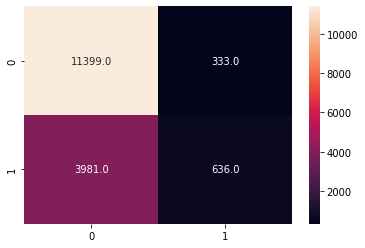

In [64]:
cf_matrix = confusion_matrix(y_train, pred_train_2)
sns.heatmap(cf_matrix, annot=True, fmt='.1f')

<AxesSubplot:>

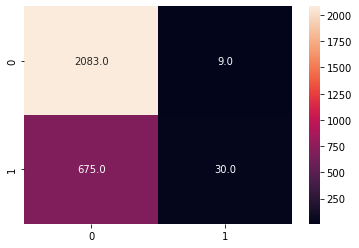

In [54]:
cf_matrix = confusion_matrix(y_test, pred_test_2)
sns.heatmap(cf_matrix, annot=True, fmt='.1f')

In [56]:
pkl_filename = "svc_model_2.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svc_2, file)

## 10 Components

In [60]:
svc_10 = SVC(random_state=42)
svc_10.fit(X_train_10, y_train)

SVC(random_state=42)

In [61]:
pred_test_10, pred_train_10, performance_df_10 = getSummary(svc_10, X_train_10, X_test_10, y_train, y_test)
performance_df_10

,Performance,Data Train,Data Test
0,Accuracy,0.821151,0.805148
1,Precision,0.730566,0.684478
2,Recall,0.801771,0.752212
3,F1,0.752709,0.704941


<AxesSubplot:>

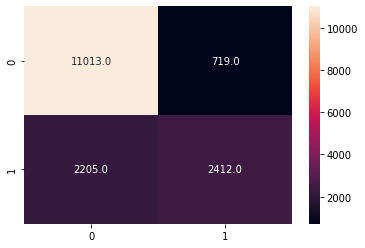

In [63]:
cf_matrix = confusion_matrix(y_train, pred_train_10)
sns.heatmap(cf_matrix, annot=True, fmt='.1f')

<AxesSubplot:>

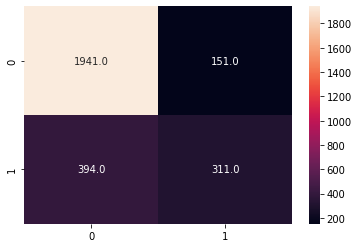

In [62]:
cf_matrix = confusion_matrix(y_test, pred_test_10)
sns.heatmap(cf_matrix, annot=True, fmt='.1f')

In [73]:
pkl_filename = "svc_model_10.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svc_10, file)

## 100 Components

In [68]:
svc_100 = SVC(random_state=42)
svc_100.fit(X_train_100, y_train)

SVC(random_state=42)

In [69]:
pred_test_100, pred_train_100, performance_df_100 = getSummary(svc_100, X_train_100, X_test_100, y_train, y_test)
performance_df_100

,Performance,Data Train,Data Test
0,Accuracy,0.887333,0.843761
1,Precision,0.833818,0.748848
2,Recall,0.879951,0.810893
3,F1,0.852522,0.771352


<AxesSubplot:>

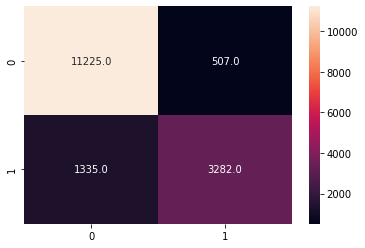

In [70]:
cf_matrix = confusion_matrix(y_train, pred_train_100)
sns.heatmap(cf_matrix, annot=True, fmt='.1f')

<AxesSubplot:>

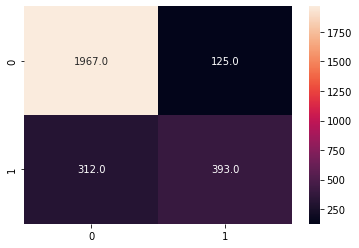

In [71]:
cf_matrix = confusion_matrix(y_test, pred_test_100)
sns.heatmap(cf_matrix, annot=True, fmt='.1f')

In [72]:
pkl_filename = "svc_model_100.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svc_100, file)

# Untuk Keperluan Error Analysis

In [75]:
train["y_pred_2"] = pred_train_2
train["y_pred_10"] = pred_train_10
train["y_pred_100"] = pred_train_100
test["y_pred_2"] = pred_test_2
test["y_pred_10"] = pred_test_10
test["y_pred_100"] = pred_test_100

In [76]:
train.to_csv("train_done.csv", index=False)

In [77]:
test.to_csv("test_done.csv", index=False)